# 학습 목표
1. 이전 수업(차등발현 분석)에서 도출된 DEG 목록을 재활용하여 Pathway/Enrichment 분석을 수행한다.
2. GSEAPY 라이브러리를 통해 Over-Representation Analysis(Enrichr)와 GSEA(prerank)를 모두 시연한다.
3. 분석 결과를 바/버블플롯 등으로 시각화하고, 생물학적 의미를 해석할 수 있다.


# 1. Pathway 분석이란?
**Pathway 분석**은 차등발현 유전자(DEG) 목록이나 전체 유전자 랭크 정보를 토대로, 특정 생물학적 기능/경로에 유전자들이 얼마나 몰려 있는지를 통계적으로 평가하는 작업임.

- Over-Representation Analysis (ORA)
  - DEG 목록만을 사용
  - 차등 발현 유전자(DEG) 리스트가 있을 때 사용
  - 계산이 빠르고 해석이 직관적
  - 유전자 발현의 크기나 순위를 고려하지 않고 특정 임계값(threshold)에 따라 유전자 리스트를 선택해야 함
- Gene Set Enrichment Analysis (GSEA)
  - 모든 유전자에 대한 log2FC, t-stat 등 정보를 사용
  - 모든 유전자에 대한 발현 데이터가 있을 때 사용
  - 계산이 상대적으로 복잡하고 시간이 오래 걸릴 수 있음



# 2. 라이브러리 설치 & 데이터 불러오기

In [ ]:
!pip install gseapy==1.0.4 --quiet   # GSEAPY (Enrichr, GSEA)
!pip install seaborn --quiet
!pip install statsmodels --quiet
!pip install mygene --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy as gp

%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 1.7 MB/s eta 0:00:00


In [ ]:
# 이전 수업에서 만든 DEG 결과 로드
# 1) 'DEG_results_significant.csv' (padj < 0.05 & |log2FC| >= 1.0 등)
# 2) 'DEG_results_full.csv'       (모든 유전자에 대한 log2FC, pvalue, etc.)

deg_signif_df = pd.read_csv("DEG_results_significant.csv", index_col=0)
deg_full_df   = pd.read_csv("DEG_results_full.csv", index_col=0)

print("Significant DEG shape:", deg_signif_df.shape)
print("Full DEG result shape:", deg_full_df.shape)

deg_signif_df.head(5)

Significant DEG shape: (3887, 8)
Full DEG result shape: (60683, 8)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,significant,-log10p
ENSEMBLID,,,,,,,,
ENSG00000227232,4.903704,2.342295,0.626870,3.736491,0.000187,0.001622,True,3.729073
ENSG00000278267,3.363780,-1.088766,0.387857,-2.807135,0.004998,0.022457,True,2.301167
ENSG00000237973,209.134172,2.618220,0.581976,4.498844,0.000007,0.000102,True,5.165427
ENSG00000229344,6.111017,1.671314,0.513333,3.255809,0.001131,0.006970,True,2.946653
ENSG00000223764,1.268480,2.296401,0.846206,2.713762,0.006652,0.027996,True,2.177022


# 3. Gene Mapping

In [ ]:
import mygene
import pandas as pd

# MyGeneInfo 객체 생성
mg = mygene.MyGeneInfo()

# Ensembl ID 리스트 추출
ensembl_ids = deg_full_df.index.tolist()

# mygene을 이용한 쿼리
#    scopes='ensembl.gene' : Ensembl gene ID로 검색
#    fields='symbol'       : Gene Symbol 정보를 가져옴
#    species='human'       : 인간 유전자
query_res = mg.querymany(ensembl_ids,
                         scopes='ensembl.gene',
                         fields='symbol',
                         species='human')

# 쿼리 결과를 바탕으로 {Ensembl ID : Gene Symbol} 매핑 딕셔너리 생성
symbol_map = {}
for item in query_res:
    ensembl_id = item['query']
    if 'notfound' not in item or not item['notfound']:
        # Gene Symbol이 존재하면 그 값을 매핑
        symbol_map[ensembl_id] = item.get('symbol', ensembl_id)
    else:
        # 매핑이 안 될 경우, NA 처리
        symbol_map[ensembl_id] = 'NA'

# 기존 DataFrame에 GeneSymbol 컬럼 추가
deg_full_df['GeneSymbol'] = deg_full_df.index.map(symbol_map)
deg_signif_df['GeneSymbol'] = deg_signif_df.index.map(symbol_map)

# 결과 확인
deg_full_df.head()

INFO:biothings.client:querying 1-1000 ...
INFO:biothings.client:querying 1001-2000 ...
INFO:biothings.client:querying 2001-3000 ...
INFO:biothings.client:querying 3001-4000 ...
INFO:biothings.client:querying 4001-5000 ...
INFO:biothings.client:querying 5001-6000 ...
INFO:biothings.client:querying 6001-7000 ...
INFO:biothings.client:querying 7001-8000 ...
INFO:biothings.client:querying 8001-9000 ...
INFO:biothings.client:querying 9001-10000 ...
INFO:biothings.client:querying 10001-11000 ...
INFO:biothings.client:querying 11001-12000 ...
INFO:biothings.client:querying 12001-13000 ...
INFO:biothings.client:querying 13001-14000 ...
INFO:biothings.client:querying 14001-15000 ...
INFO:biothings.client:querying 15001-16000 ...
INFO:biothings.client:querying 16001-17000 ...
INFO:biothings.client:querying 17001-18000 ...
INFO:biothings.client:querying 18001-19000 ...
INFO:biothings.client:querying 19001-20000 ...
INFO:biothings.client:querying 20001-21000 ...
INFO:biothings.client:querying 2100

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,significant,-log10p,GeneSymbol
ENSEMBLID,,,,,,,,,
ENSG00000223972,0.173722,0.981208,2.158106,0.454662,0.649353,NaN,False,0.187519,DDX11L1
ENSG00000227232,4.903704,2.342295,0.626870,3.736491,0.000187,0.001622,True,3.729073,WASH7P
ENSG00000278267,3.363780,-1.088766,0.387857,-2.807135,0.004998,0.022457,True,2.301167,MIR6859-1
ENSG00000243485,0.111585,0.641752,2.720343,0.235909,0.813504,NaN,False,0.089641,MIR1302-2HG
ENSG00000284332,0.000000,NaN,NaN,NaN,NaN,NaN,False,NaN,MIR1302-2


In [ ]:
# 'NA'로 표시된 행 제외하기 (deg_full_df)
deg_full_df = deg_full_df[deg_full_df['GeneSymbol'] != 'NA']

# 'NA'로 표시된 행 제외하기 (deg_signif_df)
deg_signif_df = deg_signif_df[deg_signif_df['GeneSymbol'] != 'NA']
deg_full_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,significant,-log10p,GeneSymbol
ENSEMBLID,,,,,,,,,
ENSG00000223972,0.173722,0.981208,2.158106,0.454662,0.649353,NaN,False,0.187519,DDX11L1
ENSG00000227232,4.903704,2.342295,0.626870,3.736491,0.000187,0.001622,True,3.729073,WASH7P
ENSG00000278267,3.363780,-1.088766,0.387857,-2.807135,0.004998,0.022457,True,2.301167,MIR6859-1
ENSG00000243485,0.111585,0.641752,2.720343,0.235909,0.813504,NaN,False,0.089641,MIR1302-2HG
ENSG00000284332,0.000000,NaN,NaN,NaN,NaN,NaN,False,NaN,MIR1302-2
...,...,...,...,...,...,...,...,...,...
ENSG00000271254,56.317794,-0.080459,0.186914,-0.430457,0.666863,0.782847,False,0.175963,LOC124905564
ENSG00000275405,11.395651,-0.049760,0.372417,-0.133614,0.893708,0.938426,False,0.048805,LOC124905573
ENSG00000275987,0.048242,0.641753,3.085890,0.207964,0.835257,NaN,False,0.078180,U1


# 4. Over-Representation Analysis(ORA) with Enrichr

ORA 방식:
- Enrichr (GSEAPY의 enrichr 함수 이용)
- 유의 DEG 목록을 gene_list로 입력
- 특정 데이터베이스(예: KEGG_2016, GO_Biological_Process_2021, Reactome_2016, WikiPathways 등) 지정 가능
- 결과: p-value, adj_p, 유전자 overlap, description 등

(참고) gseapy.enrichr 문서:
https://gseapy.readthedocs.io/en/latest/gseapy_example.html#1-enrich

## 주요 데이터베이스
- KEGG (KEGG_2016)
    - 경로 지도 제공
    - 다양한 대사 및 신호전달 경로를 시각적 지도 형태로 제공
    - 생리적 및 병리적 상태 분석에 널리 활용
- Reactome (Reactome_2016)
    - 인간 중심의 반응 및 분자 이벤트를 세밀하게 주석 처리하여 제공합니다.
    - 수작업으로 검토된 데이터를 바탕으로 높은 신뢰도의 경로 정보를 제공합니다.
- GO (Gene Ontology)
    - 생물학적 과정, 분자 기능, 세포 구성 요소를 계층적으로 분류
    - 유전자 기능 간의 상위/하위 관계를 쉽게 이해할 수 있도록 도와줌
- WikiPathways
    - 연구자들이 직접 기여하여 최신 경로 정보를 반영
    - 최신 연구 결과를 바탕으로 다양한 생물학적 경로를 동적으로 업데이트합니다.

In [ ]:
# 유의 DEG 목록만 추출
deg_genes = deg_signif_df.GeneSymbol.tolist()
print("Number of input genes for ORA:", len(deg_genes))

# Enrichr 실행 (KEGG)
enr_kegg = gp.enrichr(
    gene_list=deg_genes,
    gene_sets=["KEGG_2016"],   # 여러 리스트 가능 ["KEGG_2016","Reactome_2016"]
    organism="Human",          # ["Human","Mouse","Rat"]
    outdir="enrichr_kegg_res", # 결과 저장 폴더명
)

res_kegg = enr_kegg.res2d
print("KEGG Enrichment result shape:", res_kegg.shape)
res_kegg.head(10)

Number of input genes for ORA: 3830


/usr/local/lib/python3.11/dist-packages/gseapy/plot.py:602: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/usr/local/lib/python3.11/dist-packages/gseapy/plot.py:602: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


KEGG Enrichment result shape: (278, 10)


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2016,ECM-receptor interaction Homo sapiens hsa04512,37/82,7.111272e-08,0.000020,0,0,3.496613,57.550748,ITGB5;LAMA1;ITGB3;LAMA4;ITGA2B;LAMA3;LAMC2;LAM...
1,KEGG_2016,Nicotine addiction Homo sapiens hsa05033,19/40,4.472946e-05,0.006217,0,0,3.835146,38.408516,GRIA1;CHRNB2;GABRA2;GABRQ;GRIA2;GABRP;CHRNA4;C...
2,KEGG_2016,Neuroactive ligand-receptor interaction Homo s...,73/277,1.925300e-03,0.148682,0,0,1.521214,9.511657,CHRM2;GLP1R;OXTR;GRIK5;MLNR;GRIK2;HTR2A;HTR4;A...
3,KEGG_2016,Protein digestion and absorption Homo sapiens ...,29/90,2.139308e-03,0.148682,0,0,2.015487,12.389751,COL17A1;COL18A1;COL14A1;ELN;COL11A1;ATP1A2;SLC...
4,KEGG_2016,Retrograde endocannabinoid signaling Homo sapi...,29/101,1.280573e-02,0.600483,0,0,1.706400,7.436256,GRIA1;GRIA2;CACNA1B;CACNA1A;ADCY2;ADCY1;ADCY8;...
5,KEGG_2016,Glutamatergic synapse Homo sapiens hsa04724,32/114,1.307593e-02,0.600483,0,0,1.653578,7.171537,GRIA1;GRIA2;GRIK5;SLC1A2;SLC1A3;CACNA1A;ADCY2;...
6,KEGG_2016,Dilated cardiomyopathy Homo sapiens hsa05414,26/90,1.640466e-02,0.600483,0,0,1.720607,7.072022,RYR2;ITGB5;ITGB3;ITGA2B;ADCY2;ADCY1;ADCY8;TNF;...
7,KEGG_2016,Maturity onset diabetes of the young Homo sapi...,10/26,1.728009e-02,0.600483,0,0,2.643853,10.729285,NR5A2;PKLR;RFX6;HNF4A;ONECUT1;PAX4;HES1;PAX6;H...
8,KEGG_2016,GABAergic synapse Homo sapiens hsa04727,25/88,2.253910e-02,0.695349,0,0,1.680353,6.372746,CACNA1B;CACNA1A;ADCY2;ADCY1;SLC6A1;ADCY8;ADCY6...
9,KEGG_2016,African trypanosomiasis Homo sapiens hsa05143,12/35,2.501256e-02,0.695349,0,0,2.207242,8.141142,IL10;LOC102723407;VCAM1;PLCB4;LAMA4;IL1B;HBB;A...


# 5. ORA 결과 해석
- Adjusted P-value가 낮은 경로일수록
  DEG와 관련된 유전자들이 많이/유의하게 포함됨
- Overlapping Genes 열(Overlapping_Genes, or Genes)에서
  실제 어떤 유전자들이 그 경로에 속하는지 확인
- 예: 염증, 면역반응, 사이토카인 관련 경로들이 상위에 올라왔다면,
  COVID-19에서 면역 또는 염증 반응이 특징적으로 활성화되었음을 시사


In [ ]:
# 상위 경로 확인
res_kegg_sorted = res_kegg.sort_values("Adjusted P-value")
res_kegg_sorted.head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2016,ECM-receptor interaction Homo sapiens hsa04512,37/82,7.111272e-08,0.000020,0,0,3.496613,57.550748,ITGB5;LAMA1;ITGB3;LAMA4;ITGA2B;LAMA3;LAMC2;LAM...
1,KEGG_2016,Nicotine addiction Homo sapiens hsa05033,19/40,4.472946e-05,0.006217,0,0,3.835146,38.408516,GRIA1;CHRNB2;GABRA2;GABRQ;GRIA2;GABRP;CHRNA4;C...
2,KEGG_2016,Neuroactive ligand-receptor interaction Homo s...,73/277,1.925300e-03,0.148682,0,0,1.521214,9.511657,CHRM2;GLP1R;OXTR;GRIK5;MLNR;GRIK2;HTR2A;HTR4;A...
3,KEGG_2016,Protein digestion and absorption Homo sapiens ...,29/90,2.139308e-03,0.148682,0,0,2.015487,12.389751,COL17A1;COL18A1;COL14A1;ELN;COL11A1;ATP1A2;SLC...
4,KEGG_2016,Retrograde endocannabinoid signaling Homo sapi...,29/101,1.280573e-02,0.600483,0,0,1.706400,7.436256,GRIA1;GRIA2;CACNA1B;CACNA1A;ADCY2;ADCY1;ADCY8;...
5,KEGG_2016,Glutamatergic synapse Homo sapiens hsa04724,32/114,1.307593e-02,0.600483,0,0,1.653578,7.171537,GRIA1;GRIA2;GRIK5;SLC1A2;SLC1A3;CACNA1A;ADCY2;...
6,KEGG_2016,Dilated cardiomyopathy Homo sapiens hsa05414,26/90,1.640466e-02,0.600483,0,0,1.720607,7.072022,RYR2;ITGB5;ITGB3;ITGA2B;ADCY2;ADCY1;ADCY8;TNF;...
7,KEGG_2016,Maturity onset diabetes of the young Homo sapi...,10/26,1.728009e-02,0.600483,0,0,2.643853,10.729285,NR5A2;PKLR;RFX6;HNF4A;ONECUT1;PAX4;HES1;PAX6;H...
8,KEGG_2016,GABAergic synapse Homo sapiens hsa04727,25/88,2.253910e-02,0.695349,0,0,1.680353,6.372746,CACNA1B;CACNA1A;ADCY2;ADCY1;SLC6A1;ADCY8;ADCY6...
9,KEGG_2016,African trypanosomiasis Homo sapiens hsa05143,12/35,2.501256e-02,0.695349,0,0,2.207242,8.141142,IL10;LOC102723407;VCAM1;PLCB4;LAMA4;IL1B;HBB;A...


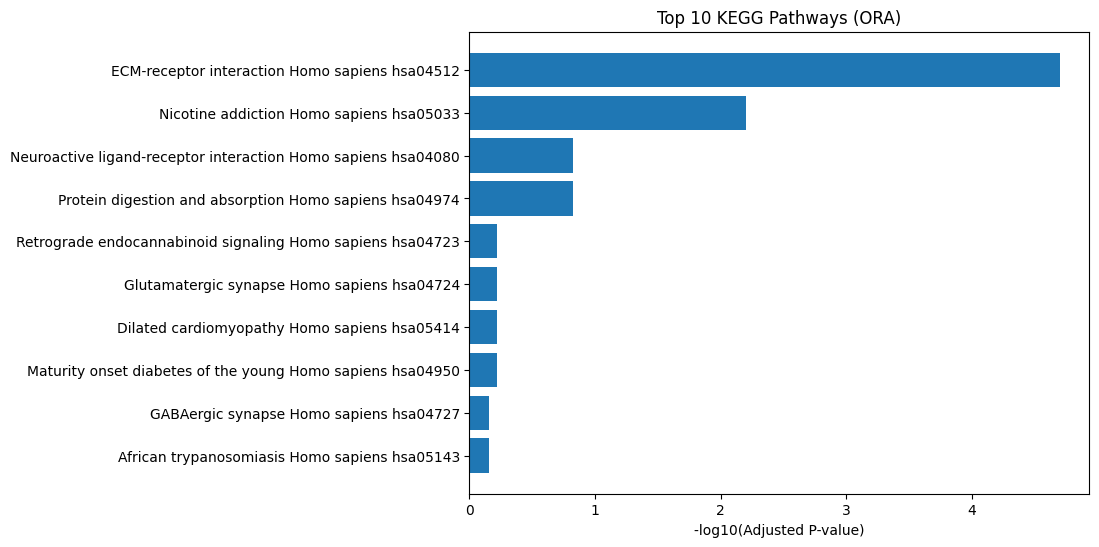

In [ ]:
# 바플롯
top_terms = res_kegg_sorted.head(10)

plt.figure(figsize=(8,6))
# -log10(Adjusted P-value) 막대
xvals = -np.log10(top_terms["Adjusted P-value"] + 1e-300)
yvals = top_terms["Term"]

plt.barh(yvals, xvals)
plt.xlabel("-log10(Adjusted P-value)")
plt.title("Top 10 KEGG Pathways (ORA)")
plt.gca().invert_yaxis()
plt.show()

# 6. GSEA(prerank)
- full 유전자 리스트(예: log2FC, t-stat 등)를 랭크로 사용
- DEG를 인위적으로 cut-off 하지 않고, 전체 유전자를
  상/하위로 skewness가 있는지 통계적으로 평가
- 'full' DataFrame에서 유전자명과 LFC(또는 statistic)으로
(ranked_list: [ (gene, score), ... ]) 구조를 만든 뒤 gseapy.prerank 함수에 전달

In [ ]:
# prerank용 dataframe 생성
# log2FoldChange가 NaN인 경우 제거
ranked_df = deg_full_df[['GeneSymbol', 'stat']].dropna()
ranked_df.columns = ['gene', 'rank']
ranked_df

,gene,rank
ENSEMBLID,,
ENSG00000223972,DDX11L1,0.454662
ENSG00000227232,WASH7P,3.736491
ENSG00000278267,MIR6859-1,-2.807135
ENSG00000243485,MIR1302-2HG,0.235909
ENSG00000240361,OR4G11P,0.152435
...,...,...
ENSG00000275063,LOC102723407,6.745062
ENSG00000271254,LOC124905564,-0.430457
ENSG00000275405,LOC124905573,-0.133614


In [ ]:
# 현재 gseapy가 지원하는 라이브러리 이름 리스트 확인
import gseapy as gp
gp.get_library_name(organism='Human')

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DGIdb_Drug_Targets_2024',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_CRISPR_GeneDependency_CellLines_2023',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_Cell

In [ ]:
# GSEA(prerank) 실행 (예: MSigDB Hallmark)
# 미리 hallmark gene sets 파일(.gmt) 준비 or gseapy 가 제공하는 것 사용
# MSigDB Hallmark: 중복되거나 불명확한 항목들을 최대한 제거하여, 50개 정도의 대표적/핵심 경로·기능만을 엄선한 집합
gsea_res = gp.prerank(
    rnk=ranked_df,
    gene_sets="MSigDB_Hallmark_2020",
    outdir="gsea_prerank_res",
    permutation_num=1000,   # permutation 횟수
    min_size=15,
    max_size=2000,
    seed=42,
)

2025-03-13 01:08:17,165 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2025-03-13 01:08:17,224 [WARNING] Duplicated values found in preranked stats: 13.60% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


# 7. GSEA 결과 해석
중요 컬럼:
- NES (Normalized Enrichment Score)
- pval, FDR(q-val)
- ES (Enrichment Score)
- tag % (해당 세트 유전자 중 상위/하위에 몇 % 분포?)

GSEA 결과 해석(Hallmark 등):
  - NES>0 & fdr<0.05: 해당 경로가 상향(Up) 쪽에 몰려있음
  - NES<0 & fdr<0.05: 하향(Down) 쪽에 몰려있음
  - 실제 hallmark/GO 용어를 확인해, 어떤 생물학적 과정을 나타내는지 분석
  - 중복되는 테마(예: Immune, Inflammatory, IL6/JAK/STAT, TNF-alpha 등)가 있으면
    질병의 핵심 기전으로 작용 가능성이 높음

In [ ]:
gsea_res_df = gsea_res.res2d
gsea_res_df.head(10)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,E2F Targets,0.758293,2.501699,0.0,0.0,0.0,90/200,4.04%,TK1;PLK1;RRM2;AURKB;CDC20;KIF4A;MKI67;BIRC5;CC...
1,prerank,G2-M Checkpoint,0.751144,2.483414,0.0,0.0,0.0,82/198,3.57%,PLK1;UBE2C;CCNA2;TPX2;AURKB;CDC20;KIF4A;MKI67;...
2,prerank,Oxidative Phosphorylation,0.742279,2.44039,0.0,0.0,0.0,127/200,11.72%,UQCRH;MRPS15;COX5A;COX6A1;NDUFS8;COX8A;HSD17B1...
3,prerank,Myc Targets V1,0.678071,2.22316,0.0,0.0,0.0,100/199,12.23%,CCNA2;CDC20;CDC45;TYMS;PRDX4;MCM2;NME1;MCM4;CO...
4,prerank,mTORC1 Signaling,0.659812,2.177817,0.0,0.0,0.0,93/199,11.98%,PLK1;RRM2;BUB1;CDC25A;MCM2;DHFR;MCM4;SDF2L1;FD...
5,prerank,TNF-alpha Signaling via NF-kB,-0.4627,-2.051726,0.0,0.0,0.0,86/198,13.06%,STAT5A;IL23A;NFE2L2;CCRL2;TGIF1;BTG2;PNRC1;CCL...
6,prerank,heme Metabolism,0.60839,2.026903,0.0,0.0,0.0,97/199,12.99%,E2F2;XK;TRIM58;SLC6A9;CA1;HBD;KLF1;SMOX;SPTB;S...
7,prerank,Coagulation,0.596502,1.917143,0.0,0.0,0.0,68/138,14.97%,CLU;SPARC;PF4;GP9;ITGB3;MMP8;GP1BA;PROS1;C1QA;...
8,prerank,Epithelial Mesenchymal Transition,0.574715,1.890556,0.0,0.000119,0.001,98/200,18.73%,SDC1;PPIB;MYL9;SPARC;PLOD2;LGALS1;ITGB3;MCM7;E...
9,prerank,Wnt-beta Catenin Signaling,-0.559625,-1.877869,0.0,0.0,0.0,17/42,9.63%,MAML1;PPARD;NOTCH1;AXIN2;LEF1;PTCH1;WNT1;AXIN1...


In [ ]:
# 상위 Pathway 시각화 (NES)
gsea_sorted = gsea_res_df.sort_values("FDR q-val", ascending=True)
gsea_sorted.head(10) # NES가 +면 활성, -면 억제

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,E2F Targets,0.758293,2.501699,0.0,0.0,0.0,90/200,4.04%,TK1;PLK1;RRM2;AURKB;CDC20;KIF4A;MKI67;BIRC5;CC...
1,prerank,G2-M Checkpoint,0.751144,2.483414,0.0,0.0,0.0,82/198,3.57%,PLK1;UBE2C;CCNA2;TPX2;AURKB;CDC20;KIF4A;MKI67;...
2,prerank,Oxidative Phosphorylation,0.742279,2.44039,0.0,0.0,0.0,127/200,11.72%,UQCRH;MRPS15;COX5A;COX6A1;NDUFS8;COX8A;HSD17B1...
3,prerank,Myc Targets V1,0.678071,2.22316,0.0,0.0,0.0,100/199,12.23%,CCNA2;CDC20;CDC45;TYMS;PRDX4;MCM2;NME1;MCM4;CO...
4,prerank,mTORC1 Signaling,0.659812,2.177817,0.0,0.0,0.0,93/199,11.98%,PLK1;RRM2;BUB1;CDC25A;MCM2;DHFR;MCM4;SDF2L1;FD...
5,prerank,TNF-alpha Signaling via NF-kB,-0.4627,-2.051726,0.0,0.0,0.0,86/198,13.06%,STAT5A;IL23A;NFE2L2;CCRL2;TGIF1;BTG2;PNRC1;CCL...
6,prerank,heme Metabolism,0.60839,2.026903,0.0,0.0,0.0,97/199,12.99%,E2F2;XK;TRIM58;SLC6A9;CA1;HBD;KLF1;SMOX;SPTB;S...
7,prerank,Coagulation,0.596502,1.917143,0.0,0.0,0.0,68/138,14.97%,CLU;SPARC;PF4;GP9;ITGB3;MMP8;GP1BA;PROS1;C1QA;...
9,prerank,Wnt-beta Catenin Signaling,-0.559625,-1.877869,0.0,0.0,0.0,17/42,9.63%,MAML1;PPARD;NOTCH1;AXIN2;LEF1;PTCH1;WNT1;AXIN1...
14,prerank,Glycolysis,0.549874,1.799996,0.0,0.000073,0.001,84/197,16.59%,KIF20A;CENPA;HMMR;DEPDC1;SDC1;CDK1;CHPF;TXN;AU...


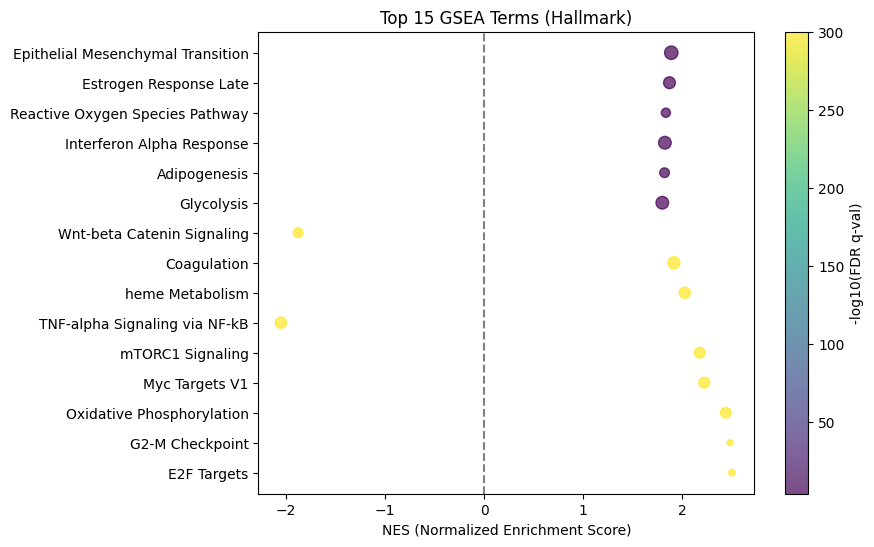

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

top_gsea = gsea_sorted.head(15).copy()

# Gene % -> 숫자로 변환
top_gsea["Gene % numeric"] = (
    top_gsea["Gene %"]
    .astype(str)               # 혹시 float로 인식되는 셀도 있으므로 문자열로 통일
    .str.replace('%','')       # '%' 제거
    .astype(float)             # float 변환
)

# FDR q-val -> float 변환 & 0/NaN 보정
top_gsea["FDR q-val"] = pd.to_numeric(top_gsea["FDR q-val"], errors="coerce").fillna(1.0)

# log10 계산 시 0 문제 방지
fdr_clipped = top_gsea["FDR q-val"].clip(lower=1e-300)
colors = -np.log10(fdr_clipped)

# x축: NES, y축: Term
xvals = top_gsea["NES"]
yvals = top_gsea["Term"]

# 점 크기: Gene % numeric
sizes = top_gsea["Gene % numeric"] * 5

plt.figure(figsize=(8,6))
scatter = plt.scatter(xvals, yvals, s=sizes, c=colors, cmap="viridis", alpha=0.7)
cbar = plt.colorbar(scatter)
cbar.set_label("-log10(FDR q-val)")
plt.axvline(0, color="gray", linestyle="--")
plt.xlabel("NES (Normalized Enrichment Score)")
plt.title("Top 15 GSEA Terms (Hallmark)")
plt.show()